**pip install azure-storage-blob**

In [56]:
import cartopy.crs as ccrs
import os
import fsspec
import xarray as xr
import numpy as np
from azure.storage.blob import ContainerClient
import planetary_computer

In [57]:
product = 'L2__O3____'
date = '2021/01/01'

In [58]:
sas_token = planetary_computer.sas.get_token("sentinel5euwest", "sentinel-5p").token

storage_account_name = 'sentinel5euwest'
container_name = 'sentinel-5p'
storage_account_url = 'https://' + storage_account_name + '.blob.core.windows.net/'

container_client = ContainerClient(account_url=storage_account_url, 
                                   container_name=container_name,
                                   credential=sas_token)

In [59]:
prefix = '/'.join(['TROPOMI',product,date])
print('Searching for prefix {}'.format(prefix))
generator = container_client.list_blobs(name_starts_with=prefix)
scene_paths = [blob.name for blob in generator]
print('\nFound {} matching scenes:\n'.format(len(scene_paths)))
for s in scene_paths:
    print(s.split('/')[-1])

Searching for prefix TROPOMI/L2__O3____/2021/01/01

Found 14 matching scenes:

S5P_OFFL_L2__O3_____20210101T013036_20210101T031206_16680_01_020104_20210102T182728.nc
S5P_OFFL_L2__O3_____20210101T031206_20210101T045336_16681_01_020104_20210102T203532.nc
S5P_OFFL_L2__O3_____20210101T045336_20210101T063506_16682_01_020104_20210102T224247.nc
S5P_OFFL_L2__O3_____20210101T063506_20210101T081636_16683_01_020104_20210103T000719.nc
S5P_OFFL_L2__O3_____20210101T081636_20210101T095806_16684_01_020104_20210103T013023.nc
S5P_OFFL_L2__O3_____20210101T095806_20210101T113936_16685_01_020104_20210103T031528.nc
S5P_OFFL_L2__O3_____20210101T113936_20210101T132106_16686_01_020104_20210103T052522.nc
S5P_OFFL_L2__O3_____20210101T132106_20210101T150236_16687_01_020104_20210103T065107.nc
S5P_OFFL_L2__O3_____20210101T150236_20210101T164406_16688_01_020104_20210103T081248.nc
S5P_OFFL_L2__O3_____20210101T164406_20210101T182536_16689_01_020104_20210103T101745.nc
S5P_OFFL_L2__O3_____20210101T182536_20210101T200706

In [60]:
offl_scenes = [s for s in scene_paths if 'OFFL' in s]
# scene_path = offl_scenes[len(offl_scenes) // 2]
scene_path = offl_scenes[1]

url = storage_account_url + container_name + '/' + scene_path
signed_url = planetary_computer.sign(url)
print('Processing image at URL:\n{}'.format(url))

Processing image at URL:
https://sentinel5euwest.blob.core.windows.net/sentinel-5p/TROPOMI/L2__O3____/2021/01/01/S5P_OFFL_L2__O3_____20210101T031206_20210101T045336_16681_01_020104_20210102T203532/S5P_OFFL_L2__O3_____20210101T031206_20210101T045336_16681_01_020104_20210102T203532.nc


In [61]:
f = fsspec.open(signed_url).open()
ds = xr.open_dataset(f, group='/PRODUCT', engine="h5netcdf")
print(ds)


<xarray.Dataset>
Dimensions:                                (scanline: 4173, ground_pixel: 450,
                                            time: 1, corner: 4, layer: 14,
                                            level: 15)
Coordinates:
  * scanline                               (scanline) float64 0.0 ... 4.172e+03
  * ground_pixel                           (ground_pixel) float64 0.0 ... 449.0
  * time                                   (time) datetime64[ns] 2021-01-01
  * corner                                 (corner) float64 0.0 1.0 2.0 3.0
  * layer                                  (layer) int32 0 1 2 3 ... 10 11 12 13
  * level                                  (level) int32 0 1 2 3 ... 11 12 13 14
Data variables:
    latitude                               (time, scanline, ground_pixel) float32 ...
    longitude                              (time, scanline, ground_pixel) float32 ...
    delta_time                             (time, scanline, ground_pixel) datetime64[ns] ...
    ti

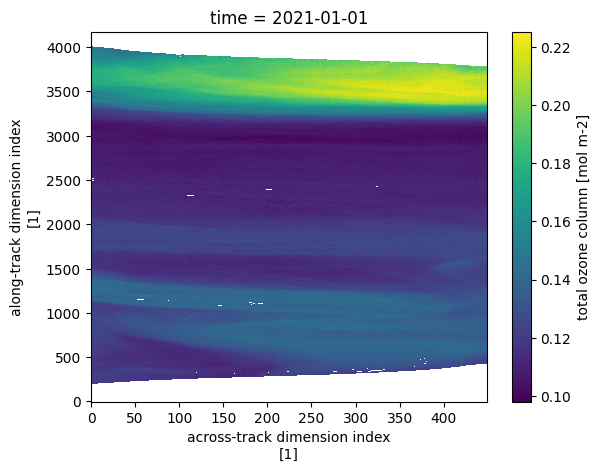

In [62]:
if 'CH4' in product:
    varname = 'methane_mixing_ratio'
elif 'NO2' in product:
    varname = 'nitrogendioxide_tropospheric_column'
elif 'O3' in product:
    varname = 'ozone_total_vertical_column'
elif 'CO' in product:
    varname = 'carbonmonoxide_total_column'
elif 'SO2' in product:
    varname = 'sulfurdioxide_total_vertical_column'
    
data = ds[varname][0,:,:]
data.plot();

In [69]:
z = data.values
lon = ds['longitude'].values.squeeze()
lat = ds['latitude'].values.squeeze()

# Don't plot extreme latitudes; they make it hard to zoom in a nice way
minlat = -60; maxlat = 60
# minlat = -90; maxlat = 90


# Zoom to a sensible longitude area by plotting only values that are non-nan
# and above a threshold.
plot_threshold = np.nanpercentile(z,50)

valid_indices = np.argwhere((~np.isnan(z)) & (z > plot_threshold))

minlon = None; maxlon = None
for xy in valid_indices:
    xy_lon = lon[xy[0],xy[1]]
    xy_lat = lat[xy[0],xy[1]]
    if xy_lat > maxlat or xy_lat < minlat:
        continue
    if minlon is None or xy_lon < minlon:
        minlon = xy_lon
    if maxlon is None or xy_lon > maxlon:
        maxlon = xy_lon

plot_extent = (minlon, maxlon, minlat, maxlat)

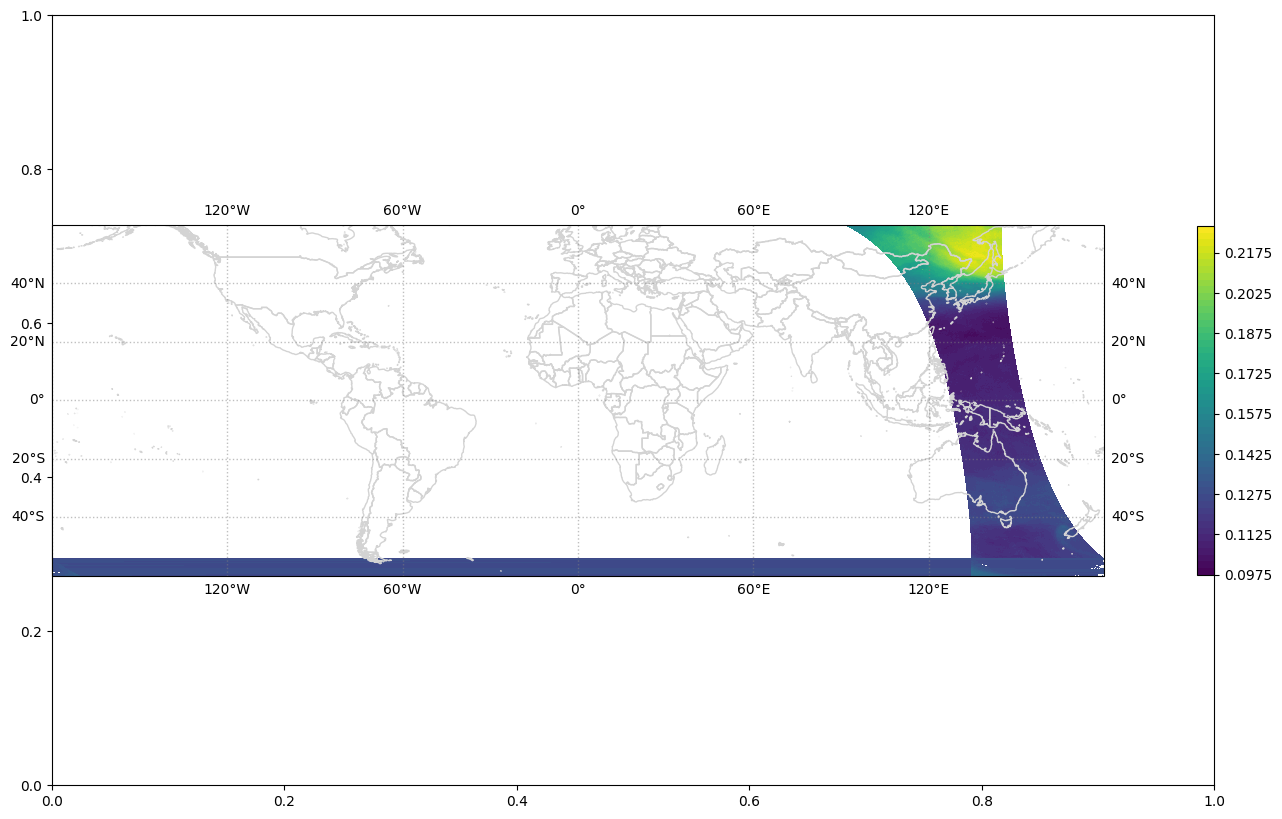

In [70]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import NaturalEarthFeature

figure, ax = plt.subplots(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0))

# Prepare the background and axes
boundaries = cfeature.NaturalEarthFeature(
    category='cultural',name='admin_0_countries',scale='50m',facecolor='none')
ax.add_feature(boundaries, edgecolor='lightgray')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':')
gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER
ax.set_extent(plot_extent,ccrs.PlateCarree())

# Plot
plt.contourf(lon, lat, z, 50, transform=ccrs.PlateCarree())
plt.colorbar(fraction=0.015, pad=0.08)
plt.show()